# Plot Anomalies 3D

This file finds anomalies in a node, according to 4 different methods: `Isolation Forest`, `Extended Isolation Forest`, `Matrix Profile` and `Auto Encoder`, and plot them on 3D (EC, TEMP, PH).

**Import Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import eif
from kando import kando_client
import pickle

# import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import eif as iso

**Global Variables**

In [3]:
WINDOW = 24
NODE = 883

**Functions**

In [4]:
def load_point_mps(point_id):
    """
    :param point_id: id number of the requested point
    :return: dictionary with matrix profiles for each field, and multivariant that includes all 
    """
    
    infile = open(f"Data_and_Mps/{point_id}_mps.pkl",'rb')
    mps = pickle.load(infile)
    infile.close()
    return(mps)

In [5]:
def load_point_data(point_id):
    """
    :param point_id: id number of the requested point
    :return: dataframe of the pre processed data of the point
    """
    
    infile = open(f"Data_and_Mps/{point_id}_data.pkl",'rb')
    df = pickle.load(infile)
    infile.close()
    return(df)

In [6]:
def add_matrix_profile_anomalies_labels(df, mps):
    """
    :param df: dataframe of the pre processed data of the point
    :param mps: dictionary with matrix profiles for each field, and multivariant that includes all 
    :return: the given df with addition of one hot encoded columns for each var,
             and for the combination of all of them that indicates matrix profile anomalies.
    """
    
    for col_ in ['EC', 'PH', 'ORP', 'TEMPERATURE']:
        df[f'{col_}_mp'] = 0
        matrix_profile = mps[f'mp_{col_}'][:, 0]
        max_index = np.argwhere(
            matrix_profile == matrix_profile.max()).flatten()[0]
        df[f'{col_}_mp'].iloc[max_index:max_index + WINDOW] = 1
    df['ALL_DIMS_mp'] = 0
    matrix_profile = mps[f'All_dimensions'][0][:, 0]
    max_index = np.argwhere(
        matrix_profile == matrix_profile.max()).flatten()[0]
    df['ALL_DIMS_mp'].iloc[max_index:max_index + WINDOW] = 1
    df['NORMAL_mp'] = 1
    df['NORMAL_mp'][(df['EC_mp'] == 1) | (df['PH_mp'] == 1) |
                    (df['ORP_mp'] == 1) | (df['TEMPERATURE_mp'] == 1) |
                    (df['ALL_DIMS_mp'] == 1)] = 0
    return (df)

In [7]:
def plot__matrix_profile_anomalies(df):
    """
    :param df: dataframe with hot encoded columns for each var,
               and for the combination of all of them that indicates matrix profile anomalies.
    :return: 3D of plot the data and the anomalies, axes are - PH,EC, and TEMPERATURE.
    """
    
    mp_cols = ['NORMAL_mp', 'ALL_DIMS_mp', 'EC_mp', 'PH_mp', 'ORP_mp', 'TEMPERATURE_mp']
    colors = ['blue', 'black', 'red', 'green', 'yellow', 'orange']
    labels = ['NORMAL', 'ALL DIMS', 'EC', 'PH', 'ORP', 'TEMPERATURE']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(6):
        x = df['PH'][df[mp_cols[i]] == 1]
        y = df['EC'][df[mp_cols[i]] == 1]
        z = df['TEMPERATURE'][df[mp_cols[i]] == 1]

        tmp_color = colors[i]
        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.05
            tmp_edgecolor = None
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            marker = '*'

        scatter = ax.scatter(x,
                             y,
                             z,
                             c=tmp_color,
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=labels[i])
    plt.legend(title='ANOMALY\n   TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('MATRIX PROFILE ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

In [8]:
def add_isolation_forest_anomalies_labels(df):
    """
    :param df: dataframe of the pre processed data of the point
    :return: the given df with addition of one hot encoded columns for each var,
             and for the combination of all of them that indicates Isolation forest anomalies.
    """

    # normalize the data
    x = df[['EC', 'PH', 'ORP', 'TEMPERATURE']].values  #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    clf = IsolationForest(random_state=0)
    clf.fit(x_scaled)

    isolation_forest_anomaly_score = clf.decision_function(x_scaled)
    df['ALL_DIMS_if'] = 0

    min_multivariant_indices = np.argpartition(isolation_forest_anomaly_score,
                                               WINDOW)
    min_multivariant_indices = min_multivariant_indices[:WINDOW]

    df['ALL_DIMS_if'][min_multivariant_indices] = 1

    indx = np.arange(df.shape[0])
    for col in ['EC', 'PH', 'ORP', 'TEMPERATURE']:
        df[f'{col}_if'] = 0
        values = df[col].values
        tempdf = pd.DataFrame({
            'time': indx,
            'ph': values,
        })
        clf.fit(tempdf)
        isolation_forest_anomaly_score = clf.decision_function(tempdf)
        temp_min_indices = np.argpartition(isolation_forest_anomaly_score,
                                           WINDOW)
        temp_min_indices = temp_min_indices[:WINDOW]
        df[f'{col}_if'][temp_min_indices] = 1
    df['NORMAL_if'] = 1
    df['NORMAL_if'][(df['EC_if'] == 1) | (df['PH_if'] == 1) |
                    (df['ORP_if'] == 1) | (df['TEMPERATURE_if'] == 1) |
                    (df['ALL_DIMS_if'] == 1)] = 0
    return (df)

In [9]:
def plot__isolation_forest_anomalies(df):
    """
    :param df: dataframe with hot encoded columns for each var,
               and for the combination of all of them that indicates Isolation Forest detected anomalies.
    :return: 3D of plot the data and the anomalies, axes are - PH,EC, and TEMPERATURE.
    """
        
    if_cols = ['NORMAL_if', 'ALL_DIMS_if', 'EC_if', 'PH_if', 'ORP_if', 'TEMPERATURE_if', ]
    colors = ['blue', 'black', 'red', 'green', 'yellow', 'orange']
    labels = ['NORMAL', 'ALL DIMS', 'EC', 'PH', 'ORP', 'TEMPERATURE']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(6):
        x = df['PH'][df[if_cols[i]] == 1]
        y = df['EC'][df[if_cols[i]] == 1]
        z = df['TEMPERATURE'][df[if_cols[i]] == 1]

        tmp_color = colors[i]
        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.05
            tmp_edgecolor = None
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            marker = '*'


        scatter = ax.scatter(x,
                             y,
                             z,
                             c=tmp_color,
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=labels[i])
    plt.legend(title='ANOMALY\n   TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('ISOLATION FOREST ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

In [10]:
def vae_input_preprocessing(df):
    """
    :param df: dataframe of the pre processed data of the point
    :return: rescaled and reshaped data compatable to use in the autoencoder model
    """
        
    # normalize the data
    x = df[['EC', 'PH', 'ORP', 'TEMPERATURE']].values  #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    # reshape inputs for LSTM [samples, timesteps, features]
    vae_input = x_scaled.reshape(x_scaled.shape[0], 1, x_scaled.shape[1])
    return (vae_input)

In [11]:
def autoencoder_model(X):
    """
    :param X: dataframe of the autoencoder model input
    :return model: autoencoder model
    """

    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16,
              activation='relu',
              return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [12]:
def add_vae_anomalies_labels(df, model):
    """
    :param  df: dataframe of the pre processed data of the point
    :return df: the given df with addition of one hot encoded column that indicates Auto Incoder detected anomalies.
             Auto Incoder detected anomalies are the WINDOW amount of most anomulous points.
    """

    X_pred = model.predict(vae_input)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=['EC', 'PH', 'ORP', 'TEMPERATURE'])
    X_pred.index = df.index

    Xtrain = vae_input.reshape(vae_input.shape[0], vae_input.shape[2])

    scored_train = pd.DataFrame(index=df.index)
    scored_train['Loss_mae'] = np.mean(np.abs(X_pred - Xtrain), axis=1)

    df['auto encoder Anomaly'] = 0
    df['auto encoder Anomaly'][scored_train['Loss_mae'].nlargest(
        n=WINDOW, keep='first').index] = 1
    return (df)

In [13]:
def plot_vae_anomalies(df):
    """
    :param df: dataframe with hot encoded column that indicates Auto Incoder detected anomalies.
    :return: 3D of plot the data and the anomalies, axes are - PH,EC, and TEMPERATURE.
    """

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(2):
        x = df['PH'][df['auto encoder Anomaly'] == i]
        y = df['EC'][df['auto encoder Anomaly'] == i]
        z = df['TEMPERATURE'][df['auto encoder Anomaly'] == i]

        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.05
            tmp_edgecolor = None
            color = 'blue'
            label = 'NORMAL'
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            color = 'black'
            label = 'ALL DIMS'
            marker = '*'

        scatter = ax.scatter(x,
                             y,
                             z,
                             c=color,
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=label)
    plt.legend(title=' TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('AUTO ENCODER ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

In [14]:
def train_auto_encoder(df):
    """
    :param  df: dataframe of the pre processed data of the point
    :return model: trained autoencoder model
    """

    vae_input = vae_input_preprocessing(df)

    # create the autoencoder model

    model = autoencoder_model(vae_input)
    model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    model.summary()

    # fit the model to the data

    nb_epochs = 50
    batch_size = WINDOW
    history = model.fit(vae_input,
                        vae_input,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        validation_split=0.15).history
    return model, vae_input

In [15]:
def add_extended_isolation_forest_anomalies_labels(df):
    """
    :param df: dataframe of the pre processed data of the point
    :return: the given df with addition of one hot encoded columns for each var,
             and for the combination of all of them that indicates Extended Isolation forest anomalies.
    """
    
    # normalize the data
    x = df[['EC', 'PH', 'ORP', 'TEMPERATURE']].values  #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    if_eif = iso.iForest(x_scaled,
                         ntrees=100,
                         sample_size=256,
                         ExtensionLevel=3)

    # calculate anomaly scores
    anomaly_scores = if_eif.compute_paths(X_in=x_scaled)
    max_indices = anomaly_scores.argsort()[-WINDOW:][::-1]
    df['ALL_DIMS_eif'] = 0
    df['ALL_DIMS_eif'][max_indices] = 1
    
    indx = np.arange(df.shape[0])
    for col in ['EC', 'PH', 'ORP', 'TEMPERATURE']:
        df[f'{col}_eif'] = 0
        values = df[col].values
        tempdf = pd.DataFrame({
            'time': indx,
            'ph': values,
        })
        anomaly_score = iso.iForest(tempdf.values, 
                         ntrees = 100, 
                         sample_size = 256, 
                         ExtensionLevel = 1)
        anomaly_scores = if_eif.compute_paths(X_in = tempdf.values)
        max_indices = anomaly_scores.argsort()[-WINDOW:][::-1]
        df[f'{col}_eif'][max_indices] = 1

    df['NORMAL_eif'] = 1
    df['NORMAL_eif'][(df['EC_eif'] == 1) | (df['PH_eif'] == 1) | (df['ORP_eif'] == 1) |
                    (df['TEMPERATURE_eif'] == 1) | (df['ALL_DIMS_eif'] == 1)] = 0
    return (df)

In [16]:
def plot_extended_isolation_forest(df):
    """
    :param df: dataframe with hot encoded columns for each var,
               and for the combination of all of them that indicates Extended Isolation Forest detected anomalies.
    :return: 3D of plot the data and the anomalies, axes are - PH,EC, and TEMPERATURE.
    """

    eif_cols = ['NORMAL_eif', 'ALL_DIMS_eif', 'EC_eif', 'PH_eif', 'ORP_eif', 'TEMPERATURE_eif', ]
    colors = ['blue', 'black', 'red', 'green', 'yellow', 'orange']
    labels = ['NORMAL', 'ALL DIMS', 'EC', 'PH', 'ORP', 'TEMPERATURE']

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(6):
        x = df['PH'][df[eif_cols[i]] == 1]
        y = df['EC'][df[eif_cols[i]] == 1]
        z = df['TEMPERATURE'][df[eif_cols[i]] == 1]

        tmp_color = colors[i]
        if i == 0:
            tmp_size = 90
            tmp_alpha = 0.03
            tmp_edgecolor = None
            marker = '.'
        else:
            tmp_size = 130
            tmp_alpha = 0.8
            tmp_edgecolor = 'black'
            marker = '*'

        scatter = ax.scatter(x,
                             y,
                             z,
                             c=colors[i],
                             marker=marker,
                             cmap=plt.cm.Spectral_r,
                             alpha=tmp_alpha,
                             s=tmp_size,
                             edgecolor=tmp_edgecolor,
                             label=labels[i])
    plt.legend(title=' TYPE')

    ax.set_xlabel('PH')
    ax.set_ylabel('EC')
    ax.set_zlabel('TEMPERATURE')

    plt.title('EXTENDED ISOLATION FOREST ANOMALIES\n', FontSize=16, FontWeight='bold')

    plt.show()

In [17]:
def save_df_with_anomalies(df, point_id):
    """
    :param df: dataframe with hot encoded columns for all detected anomalies.
    :return: saves a pickle file af the dataframe
    """
        
    b_file = open(f"{point_id}_data_with_anomalies.pkl", "wb")
    pickle.dump(df, b_file)
    b_file.close()

In [18]:
mps = load_point_mps(NODE)

In [19]:
df = load_point_data(NODE)

In [20]:
with open('water_authority.json') as f:
    active_by_aouthority = json.load(f)

## MATRIX PROFILE ANOMALIES

In [21]:
df = add_matrix_profile_anomalies_labels(df, mps)

<IPython.core.display.Javascript object>


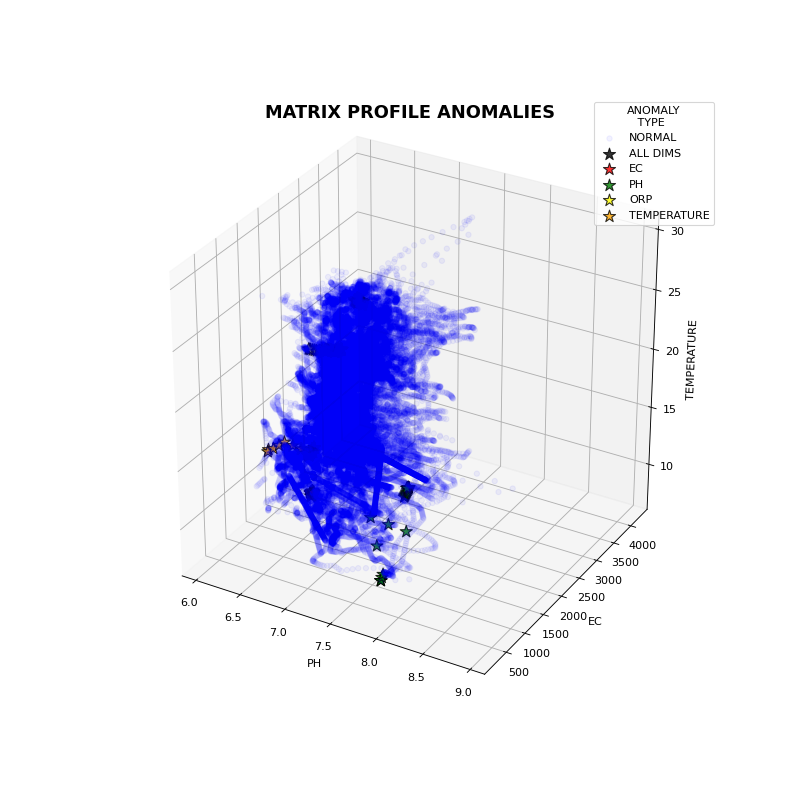

In [22]:
plot__matrix_profile_anomalies(df)

**ISOLATION FOREST ANOMALIES**

In [23]:
df = add_isolation_forest_anomalies_labels(df)

<IPython.core.display.Javascript object>


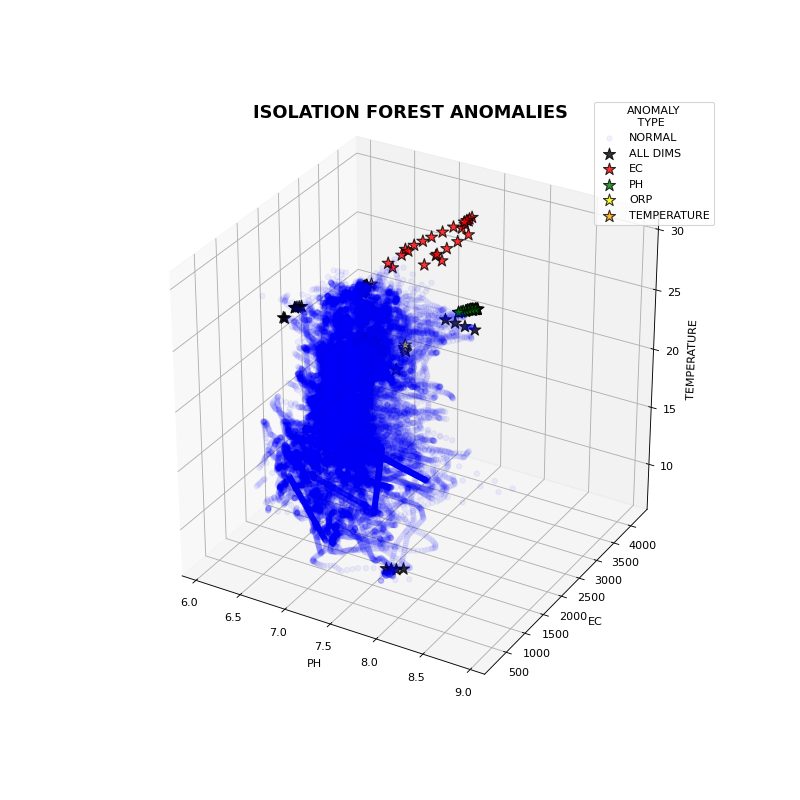

In [24]:
plot__isolation_forest_anomalies(df)

**AUTOENCODER ANOMALIES**

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)             

Epoch 49/50
1900/1900 [==============================] - 5s 3ms/step - loss: 0.0295 - accuracy: 0.9449 - val_loss: 0.0359 - val_accuracy: 0.9990
Epoch 50/50
1900/1900 [==============================] - 5s 3ms/step - loss: 0.0294 - accuracy: 0.9451 - val_loss: 0.0361 - val_accuracy: 0.9990


<IPython.core.display.Javascript object>


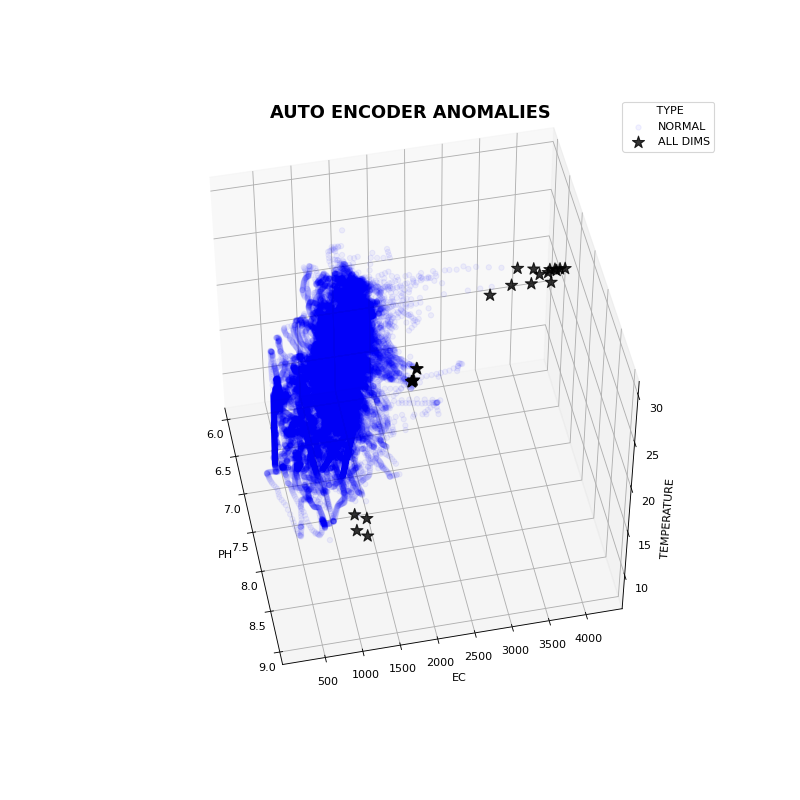

In [25]:
model, vae_input = train_auto_encoder(df)
df = add_vae_anomalies_labels(df, model)
plot_vae_anomalies(df)

**EXTENDED ISOLATION FOREST ANOMALIES**

<IPython.core.display.Javascript object>


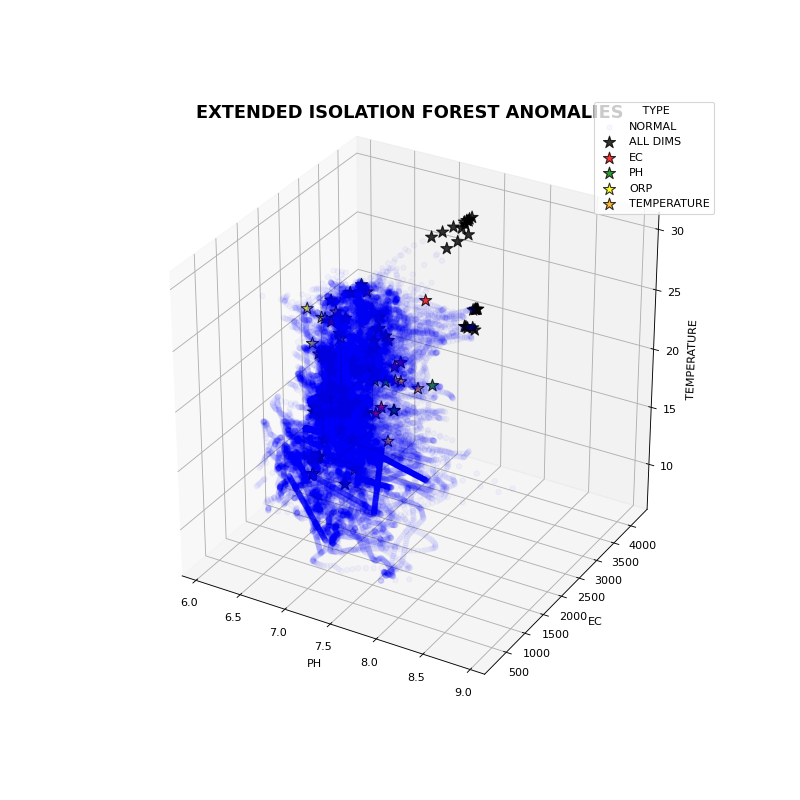

In [26]:
df = add_extended_isolation_forest_anomalies_labels(df)
plot_extended_isolation_forest(df)

In [27]:
save_df_with_anomalies(df, 911)